In [1]:
%matplotlib inline

In [2]:
# %run notebook_setup

/home/tom/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


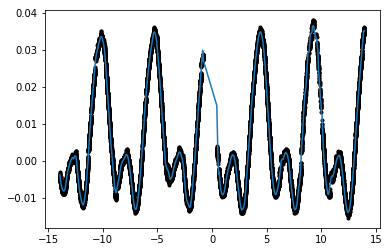

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

lc_url = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0004/4142/0236/tess2018206045859-s0001-0000000441420236-0120-s_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = lc["TIME"]
flux = lc["PDCSAP_FLUX"]
flux_err = lc["PDCSAP_FLUX_ERR"]
m = np.isfinite(time) & np.isfinite(flux) & (lc["QUALITY"] == 0)
time = time[m]
flux = flux[m]
flux_err = flux_err[m]

# Identify outliers
m = np.ones(len(flux), dtype=bool)
for i in range(10):
    y_prime = np.interp(time, time[m], flux[m])
    smooth = savgol_filter(y_prime, 301, polyorder=3)
    resid = flux - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = resid < sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Just for this demo, subsample the data
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[m], dtype=np.float64)

mu = np.median(flux)
flux = flux / mu - 1
flux_err /= mu

x = time
y = flux * 1000
yerr = flux_err * 1000

plt.plot(time, flux, ".k")
plt.plot(time, smooth[m] / mu - 1);

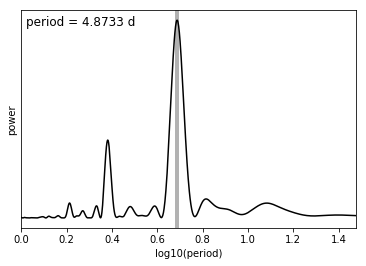

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

In [21]:
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None):
    p_period = 16.93, 30.537
    p_t0 = -8.84, -2.875
    p_depth = 0.04, 0.03
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=6, sd=10.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=5.0)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.3, 0.2]))
        R_star = 0.8, 0.1
        Rho_star = 0.8
        r_star = pm.Normal("r_star", mu=R_star[0], sd=R_star[1])
        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star), sd=1)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        logP = pm.Normal("logP", mu=np.log(p_period), sd=0.1, shape=2)
        t0 = pm.StudentT("t0", mu=p_t0, nu=1.0, sd=0.5, shape=2)
#         ror, b = xo.distributions.get_joint_radius_impact(
#             min_radius=0.001, max_radius=0.3,
#             testval_r=p_depth,
#             testval_b=0.1)
        logror = pm.Normal("logror", mu=np.log(p_depth),
                           sd=2, shape=2)
        ror = pm.Deterministic("r", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=2)
        b = pm.Deterministic("b", b_param * (1 + ror))
        ecc = pm.Bound(pm.Beta, lower=0.0, upper=1.0)("ecc", alpha=0.867, beta=3.03, testval=0.05,
                                                     shape=2)
        omega = xo.distributions.Angle("omega", shape=2)

        
        pm.Potential("ror_prior_lo", tt.switch(tt.all(0.005 < ror), 0.0, -np.inf))
        pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))  
#         pm.Potential("ror_prior", -tt.log(ror))

    #         pm.Potential("b_prior",  tt.switch(b < 1, 0, -np.inf))
        p_period = pm.Deterministic("p_period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", r_star * ror / 0.009155)
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, #m_star=m_star,
            period=p_period, t0=t0, b=b,
            rho_star=rho_star, ecc=ecc, omega=omega)
        light_curves = xo.StarryLightCurve(u_star, r_star=r_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        pm.Deterministic("light_curves", light_curves)

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        map_soln = pm.find_MAP(start=model.test_point, vars=[mean, logs2])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param, logP, t0])
        
    return model, map_soln

model0, map_soln0 = build_model()

/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
logp = -9,983.3, ||grad|| = 2,300.1: 100%|██████████| 7/7 [00:00<00:00, 63.94it/s]   
logp = -7,837, ||grad|| = 6.0131: 100%|██████████| 49/49 [00:00<00:00, 51.70it/s]    
logp = -7,819.3, ||grad|| = 0.80335: 100%|██████████| 40/40 [00:00<00:00, 49.45it/s]  
logp = -7,811.8, ||grad|| = 0.25383: 100%|██████████| 16/16 [00:00<00:00, 67.69it/s]  
logp = -7,780.1, ||grad|| = 529.22: 100%|██████████| 130/130 [00:02<00:00, 60.86it/s]  


In [22]:
map_soln0

{'mean': array(6.60584025),
 'logs2': array(-2.70540738),
 'logS': array(-6.58743567),
 'logw': array(4.55412619),
 'logamp': array(5.02133636),
 'logperiod': array(1.58376437),
 'logQ0': array(0.43972761),
 'logdeltaQ': array(8.33261695),
 'mix_interval__': array(-1.13891573),
 'u_star_quadlimbdark__': array([-1.09861229, -0.84729786]),
 'r_star': array(0.8),
 'logrho_star': array(-0.22314355),
 'logP': array([2.83099494, 3.37687535]),
 't0': array([-8.8579009 , -2.88103193]),
 'logror': array([-3.14750394, -3.66304951]),
 'b_param_interval__': array([0.35201703, 0.28081052]),
 'ecc_interval__': array([-2.94443898, -2.94443898]),
 'omega_angle__': array([[0., 0.],
        [1., 1.]]),
 'period': array(4.87326608),
 'mix': array(0.24251949),
 'u_star': array([0.3, 0.2]),
 'rho_star': array(0.8),
 'r': array([0.04295922, 0.02565416]),
 'b_param': array([0.58710662, 0.56974492]),
 'b': array([0.61232826, 0.58436125]),
 'ecc': array([0.05, 0.05]),
 'omega': array([1.57079633, 1.57079633]),

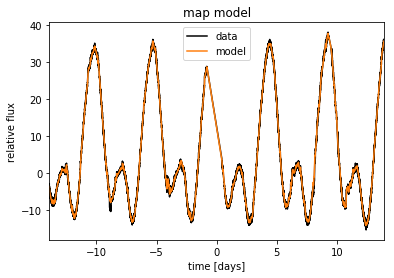

In [23]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln0["pred"] + map_soln0["mean"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("map model");

(7.5, 9)

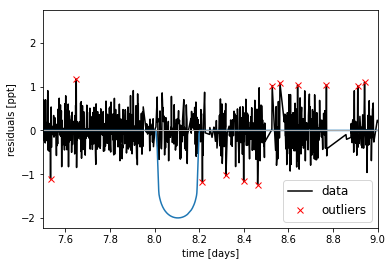

In [24]:
mod = map_soln0["pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5. * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x, np.sum(map_soln0["light_curves"], axis=-1))
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());
plt.xlim(-9.5+17,-8+17)

In [25]:
model, map_soln = build_model(mask)

/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
logp = -8,969.4, ||grad|| = 1,816: 100%|██████████| 7/7 [00:00<00:00, 66.55it/s]   
logp = -7,108.5, ||grad|| = 84.731: 100%|██████████| 49/49 [00:00<00:00, 51.89it/s]  
logp = -7,088.9, ||grad|| = 0.2155: 100%|██████████| 40/40 [00:00<00:00, 50.64it/s]  
logp = -7,080.4, ||grad|| = 0.39761: 100%|██████████| 16/16 [00:00<00:00, 68.65it/s]  
logp = -7,060.9, ||grad|| = 7.5159: 100%|██████████| 74/74 [00:01<00:00, 63.08it/s]   


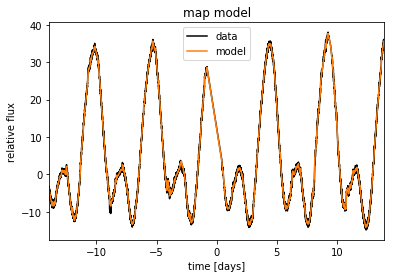

In [26]:
plt.plot(x[mask], y[mask], "k", label="data")
plt.plot(x[mask], map_soln["pred"] + map_soln["mean"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("map model");

(-3.5, -2.5)

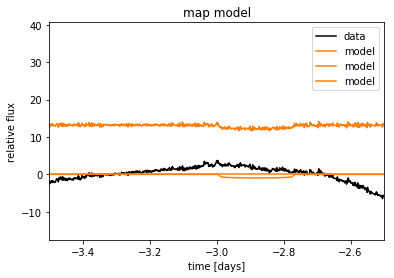

In [28]:
plt.plot(x[mask], y[mask], "k", label="data")
plt.plot(x[mask], y[mask] - map_soln["pred"] + map_soln["mean"], color="C1", label="model")
plt.plot(x[mask], map_soln["light_curves"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("map model");

plt.xlim(-10,-8)
plt.xlim(-3.5,-2.5)
# plt.ylim(-0.2,0.25)

In [29]:
sampler = xo.PyMC3Sampler(window=200, start=100, finish=1000)
with model:
    sampler.tune(tune=8000, start=map_soln, step_kwargs=dict(target_accept=0.9))

/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 1608/1608 [1:26:26<00:00, 14.28s/draws]
The chain contains only diverging samples. The model is probably misspecified.
Sampling 4 chains: 100%|██████████| 3208/3208 [2:16:00<00:00, 12.14s/draws]  
The chain contains only diverging samples. The model is probably misspecified.
The chain contains only diverging samples. The model is probably misspecified.
Sampling 4 chains: 100%|██████████| 19608/19608 [29:07:28<00:00, 13.04s/draws]   


In [30]:
with model:
    trace = sampler.sample(draws=3000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, ecc, b_param, logror, t0, logP, logrho_star, r_star, u_star, mix, logdeltaQ, logQ0, logperiod, logamp, logw, logS, logs2, mean]
/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains:  59%|█████▊    | 9365/16000 [13:34:57<11:03:23,  6.00s/draws]


KeyboardInterrupt: 

In [ ]:
period_samples = trace["period"]
plt.hist(period_samples, 35, histtype="step", color="k")
plt.yticks([])
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");
plt.tight_layout()
plt.savefig('rotation-posterior.png', dpi=200)

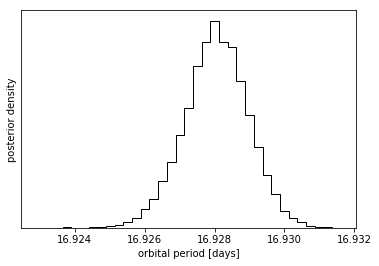

In [68]:
period_samples = trace["p_period"]
plt.hist(period_samples, 35, histtype="step", color="k")
plt.yticks([])
plt.xlabel("orbital period [days]")
plt.ylabel("posterior density");

In [69]:
map_soln

{'mean': array(6.5334408),
 'logs2': array(-2.85074089),
 'logS': array(-6.55748755),
 'logw': array(4.52273474),
 'logamp': array(5.02111413),
 'logperiod': array(1.58376437),
 'logQ0': array(0.42706864),
 'logdeltaQ': array(8.33471027),
 'mix_interval__': array(-1.14349964),
 'u_star_quadlimbdark__': array([-1.09861229, -0.84729786]),
 'r_star': array(0.8),
 'logrho_star': array(-0.22314355),
 'logP': array(2.83067819),
 't0': array(-8.85244382),
 'logror': array(-3.14164668),
 'b_param_interval__': array(0.3340272),
 'ecc_interval__': array(-2.94443898),
 'omega_angle__': array([0., 1.]),
 'period': array(4.87326608),
 'mix': array(0.2416784),
 'u_star': array([0.3, 0.2]),
 'rho_star': array(0.8),
 'r': array(0.04321158),
 'b_param': array(0.58273893),
 'b': array(0.60792001),
 'ecc': array(0.05),
 'omega': array(1.57079633),
 'p_period': array(16.95695692),
 'r_pl': array(0.03456927),
 'light_curves': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],

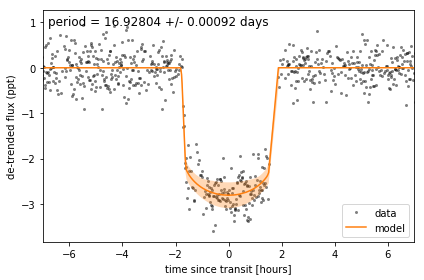

In [70]:
# Compute the GP prediction
gp_mod = np.median(trace["pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["p_period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold * 24., y[mask] - gp_mod, ".k", label="data",
         alpha=0.5, zorder=-1000, mec="none")

# # Overplot the phase binned light curve
# bins = np.linspace(-10, 10, 50)
# denom, _ = np.histogram(x_fold, bins)
# num, _ = np.histogram(x_fold, bins, weights=y[mask])
# denom[num == 0] = 1.0
# plt.plot(0.5*(bins[1:] + bins[:-1]) *  24., num / denom, "o", color="C2",
#          label="binned")

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds] * 24., pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds] * 24., pred[0], pred[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} days".format(
    np.mean(trace["p_period"]), np.std(trace["p_period"]))

plt.annotate(txt, (0, 0.9), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

# plt.annotate('AU Mic b', (0, 1), xycoords="axes fraction",
#              xytext=(5, 5), textcoords="offset points",
#              ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlabel("time since transit [hours]")
plt.ylabel("de-trended flux (ppt)")
plt.xlim(-7, 7);

plt.tight_layout()
plt.savefig('transit-plot.png', dpi=200)

In [71]:
pred = np.percentile(trace["light_curves"][:, :, 0] + trace["mean"][:, None] +
                     trace["pred"], [5,50,95], axis=0)
pred1 = np.percentile(trace["light_curves"][:, :, 0], [5,50,95], axis=0)
pred2 = np.percentile(trace["pred"] + trace["mean"][:, None], [5,50,95], axis=0)

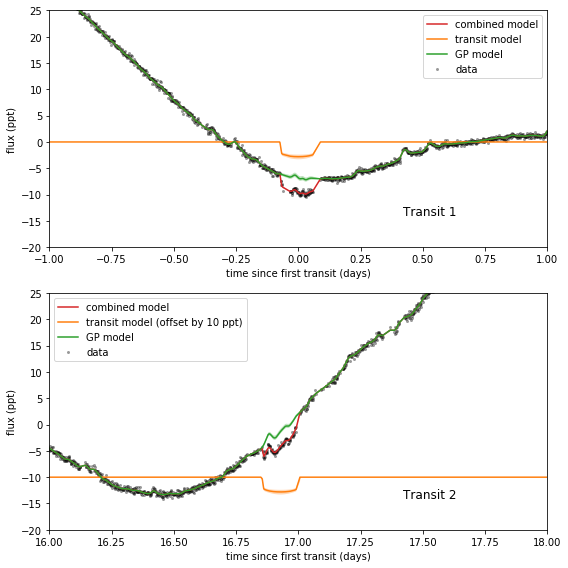

In [72]:
fig,  [ax1, ax2] = plt.subplots(2,1, figsize=[8, 8])
time = x[mask] - np.median(trace['t0'])

ax1.plot(time, pred[1], color='C3', label = 'combined model')
art = ax1.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred1[1], color='C1', label = 'transit model')
art = ax1.fill_between(time, pred1[0], pred1[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax1.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax1.set_xlim(-1,1)
ax1.set_ylim(-20, 25)

ax1.legend()
ax1.set_xlabel("time since first transit (days)")
ax1.set_ylabel("flux (ppt)")

ax1.annotate('Transit 1', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

ax2.plot(time, pred[1], color='C3', label = 'combined model')
art = ax2.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred1[1] -10, color='C1', label = 'transit model (offset by 10 ppt)')
art = ax2.fill_between(time, pred1[0] -10, pred1[2]-10, color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax2.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax2.set_xlim(16,18)
ax2.set_ylim(-20, 25)
ax2.legend()
ax2.set_xlabel("time since first transit (days)")
ax2.set_ylabel("flux (ppt)")

ax2.annotate('Transit 2', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.tight_layout()
plt.savefig('transits-GP.png', dpi=200)

(-10, -8)

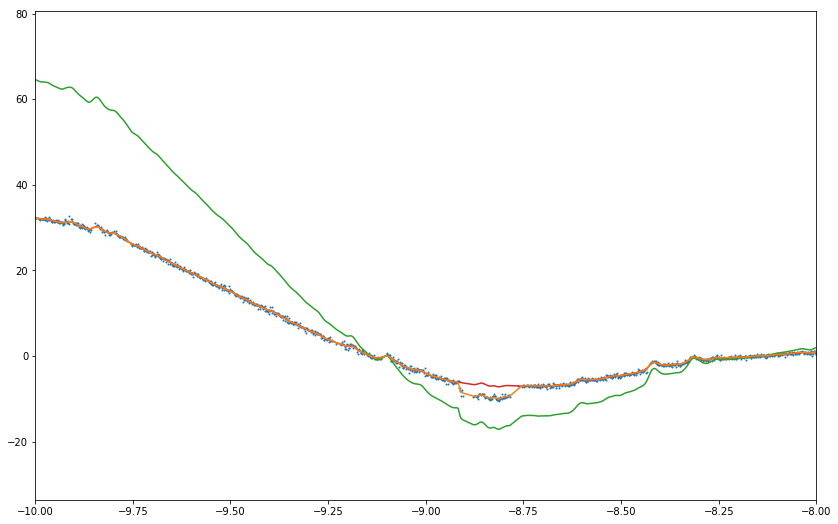

In [73]:
fig,  ax = plt.subplots(1,1, figsize=[14, 9])
plt.plot(x[mask], gp_mod, color="C3", label="model")
plt.plot(x[mask], np.percentile(pred, [50], axis=0)[0] + gp_mod, color="C2", label="model")
plt.plot(x[mask], np.percentile(pred, [50], axis=0)[0], color="C1", label="model")
plt.scatter(x,y, s=1)
plt.xlim(7-17,9-17)

In [74]:
pm.summary(trace, varnames=["logw", "logS", "logs2", "logamp", "r_pl", "logperiod", "logQ0",
                            "b", "t0", "p_period", "r_star", "rho_star", "u_star", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logw,4.252819,0.059189,0.000999,4.139407,4.367781,3092.304034,1.001519
logS,-5.878872,0.162200,0.002392,-6.201804,-5.571725,6348.484265,1.000791
logs2,-2.840050,0.020473,0.000204,-2.881315,-2.800919,11106.830601,1.000248
logamp,4.912048,0.754222,0.019943,3.622536,6.373197,799.022948,1.006572
r_pl,0.040398,0.005240,0.000055,0.030162,0.050793,10407.982182,1.000193
logperiod,1.580930,0.006748,0.000183,1.568278,1.594261,346.007915,1.008758
logQ0,1.787572,0.599593,0.013264,0.769654,3.036365,1079.647514,1.000854
b,0.312225,0.207959,0.003587,0.000052,0.695381,4313.328029,1.001336
t0,-8.843076,0.002224,0.000042,-8.846723,-8.839020,3183.933393,1.002884
p_period,16.928043,0.000917,0.000011,16.926237,16.929840,11955.934814,0.999860


In [266]:
x[mask] - np.median(trace['t0'])

array([-5.08855398, -5.08716509, -5.0857762 , ..., 22.77342696,
       22.77481579, 22.77620463])

In [165]:
import pickle
with open('my_model.pkl', 'wb') as buff:
    pickle.dump({'model': model, 'trace': trace}, buff)

In [168]:
del map_soln0

(8000, 17242)

In [13]:
np.exp(np.log(0.5)+2)

3.6945280494653248

In [ ]:
with model:
    trace = sampler.sample(draws=4)

Only 4 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, ecc, b_param, logror, t0, logP, logrho_star, r_star, u_star, mix, logdeltaQ, logQ0, logperiod, logamp, logw, logS, logs2, mean]
/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains:   4%|▎         | 148/4016 [03:11<1:26:47,  1.35s/draws]

In [ ]:
trace